In [38]:
#  Referenced https://arxiv.org/pdf/1506.01195.pdf
#  https://towardsdatascience.com/backpropagation-in-fully-convolutional-networks-fcns-1a13b75fb56a
#  https://pavisj.medium.com/convolutions-and-backpropagations-46026a8f5d2c
# https://towardsdatascience.com/backpropagation-in-a-convolutional-layer-24c8d64d8509
# https://www.coursera.org/learn/convolutional-neural-networks
# https://victorzhou.com/blog/intro-to-cnns-part-1/
# https://q-viper.github.io/2020/06/05/convolutional-neural-networks-from-scratch-on-python/
# https://datascience.stackexchange.com/questions/11699/backprop-through-max-pooling-layers
# https://leimao.github.io/blog/Max-Pooling-Backpropagation/

import numpy as np

## In this implementation of CNN, I will assume that readers have the basic neural network knowledge:  forward propagation and backward propagation 

## I will also assume that readers have CS445 computational photography knowledge, which is knowing what is a convolution, padding, and stride




#### image source https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

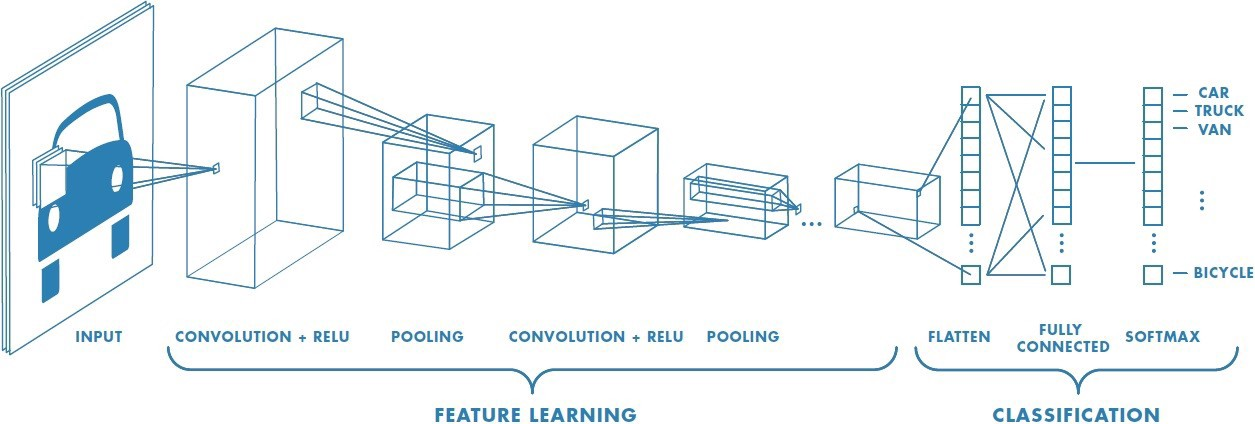

### I will try to implement the feature learning part of CNN(pooling and convolution), as that's more pertinent to this class. The classification part is just the same as any other neural network.


### Before we start, I would like to first define some variables
### Y = W* A_Prev + B,  
### 1. * denotes the convolve sign(not matrix multiplication)
### 2. W is the filter matrix, with the shape (filter_size, filter_size, num_channel_prev,  num_channel_curr)
### 3. A_Prev is the output activations of the previous layer, with the shape (num_pic, height_prev, width_prev, num_channel_prev)
### 4. B is the bias vector with the shape (1, 1, 1, num_channel_curr)



## The dimensions of the next layer after convolving will be given by the following formulas
$$Height = \Bigl\lfloor \frac{{Height_{prev}} - filter + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$Width = \Bigl\lfloor \frac{{Width_{prev}} - filter + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$ Channel = \text{number of filters used in the convolution}$$

In [68]:
def convolve_forward(A_prev, W, b, stride, pad):
    (num_pic, H_prev, W_prev, n_C_prev) = A_prev.shape
    (filter_size, filter_size, n_C_prev, new_C) = W.shape
    
    new_H = int((H_prev - filter_size+ (2 * pad))/stride) + 1
    new_W = int((W_prev- filter_size+ (2 * pad)) / stride) + 1
    
    # retrieve the dimensions of the new Y
    Y = np.zeros((num_pic, new_H, new_W, new_C))
    
    for i in range(num_pic):
        #https://numpy.org/doc/stable/reference/generated/numpy.pad.html
        # padding the height and width for each picture
        padded_A = np.pad(A_prev[i], ((pad,pad),(pad, pad),(0,0)), mode='constant', constant_values = (0,0))
        
        # loop through the image
        for h in range(new_H):
            vert_start = stride * h
            vert_end = vert_start + filter_size
            # print(vert_start, vert_end)
        
            for w in range(new_W):
                hor_start = stride * w
                hor_end = hor_start + filter_size
                # print(hor_start, hor_end)
                
                for chan in range(new_C):
                    # print(chan)
                    sliced_A = padded_A[vert_start:vert_end, hor_start: hor_end, :]

                    weight = W[:, :, :, chan]
                    bias = b[:, :, :, chan]
                    # print(padded_A.shape)
                    # print(weight.shape)
                    # do a element wise multiplication, then sum it up and + b
                   # print(np.sum(np.multiply(sliced_A, weight)))
                    Y[i,h, w, chan] = np.sum(np.multiply(sliced_A, weight)) + float(bias)
                    
                    
                    
                    
    return Y, A_prev, W, b

In [70]:
## Simple testing


np.random.seed(0)
A_prev = np.random.randn(1, 1, 1, 1)
W = np.random.randn(1, 1, 1, 1)
b = np.random.randn(1, 1, 1, 1)

Y, _, _,_ = convolve_forward(A_prev, W, b, 2, 1)


print(A_prev)
print(W)
print(b)
# the value should be equal to bias due to the smal
assert np.isclose(Y[0][0][0],0.9787, atol = 0.01)
assert Y.shape == (1,2,2,1)





A_prev = np.random.randn(2, 9, 7, 3)
W = np.random.randn(5, 5, 3, 4) # 5 by 5 filter, n_C prev = 3, n_C = 4
b = np.random.randn(1, 1, 1, 4) # bias

Y, _, _, _= convolve_forward(A_prev, W, b, 2, 1)

# num pic = 2
# height = floor(9 - 5 + 2*1 / 2) + 1 = 4
# width = floor(7 - 5 + 2*1 / 2) + 1 = 3
# chan = 4

assert Y.shape == (2,4,3,4)





[[[[1.76405235]]]]
[[[[0.40015721]]]]
[[[[0.97873798]]]]


## The conv_foward is the foward propagation step, where we get the output vector Y. We would normally put that into an activation function like 'relu' or 'sigmoid'. Then we would define a loss function and we will try to get gradients in the conv_backward step so that we can perform updates on the values

## The formula that gives the gradient of these vectors are

$$grad A \mathrel{+}= \sum _{h=0} ^{height} \sum_{w=0} ^{width} W[:,:,:c] \times grad Y[h,w,c]$$


$$grad W[:,:,:c]  \mathrel{+}= \sum _{h=0} ^{height} \sum_{w = 0} ^ {width} a_{slice} \times grad Y[h,w,c]$$

$$grad b = \sum _{h=0} ^{height} \sum_{w = 0} ^ {width} grad Y[h,w,c]$$


## We calculate these values so that we can perform updates after each iteration


In [77]:
def convolve_backward(grad_Y ,A_prev, W, b):
    (num_pic, H_prev, W_prev, Chan_prev) = A_prev.shape
    (filter_size, filter_size, Chan_prev, new_Chan) = W.shape
    

    (num_pic, new_H, new_W, new_Chan) = grad_Y.shape
    
    
    
    grad_A_prev = np.zeros(A_prev.shape)                          
    grad_W = np.zeros(W.shape)
    grad_b = np.zeros(b.shape)
    
    
    
    for i in range(num_pic): 
        pad_A = np.pad(A_prev[i], ((pad,pad),(pad, pad),(0,0)), mode='constant', constant_values = (0,0))
        
        pad_gradA = np.pad(grad_A_prev[i], ((pad,pad),(pad, pad),(0,0)), mode='constant', constant_values = (0,0))
        
        
        for h in range(new_H):                  
            vert_start = stride * h
            vert_end = vert_start + filter_size
            
            for w in range(new_W): 
                hor_start = stride * w
                hor_end = hor_start + filter_size
                for c in range(new_Chan): 
                    sliced_A = pad_A[vert_start:vert_end,hor_start:hor_end,:]
                    #print(i,h,w,c)
                    #print(W[:,:,:,c])

                    pad_gradA[vert_start:vert_end, hor_start:hor_end, :] += W[:,:,:,c] * grad_Y[i, h, w, c]
                    grad_W[:,:,:,c] += sliced_A * grad_Y[i, h, w, c]
                    #print(sliced_A)
                    grad_b[:,:,:,c] += grad_Y[i, h, w, c]
                    
                    
        # loading values to grad_A excluding pad
        grad_A_prev[i, :, :, :] = pad_gradA[pad:-pad, pad:-pad, :]

        assert(grad_A_prev.shape == (num_pic, H_prev, W_prev, Chan_prev))

                    
    return grad_A_prev, grad_W, grad_b

    

    

In [78]:
np.random.seed(1)
A_prev = np.random.randn(1, 5, 5, 3)
W = np.random.randn(1,1, 3, 3)
b = np.random.randn(1, 1, 1, 3)

pad = 1
stride = 1
Y, A_prev, W, b =  convolve_forward(A_prev, W, b,filter_size, pad )

convolve_backward(Y, A_prev, W, b)



(array([[[[-5.49685242,  1.43976779, -0.65685065],
          [-0.99273423,  0.28542074, -0.29261403],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ]],
 
         [[-0.99273423,  0.28542074, -0.29261403],
          [-0.99273423,  0.28542074, -0.29261403],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ]],
 
         [[ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ]],
 
         [[ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        

## Now I'll implement max pooling, which is to take the maximum value from the filter kernel, which reduces it's dimensions. It is used to remove certain amount of extraneous noises, and also reduce the computational cost for the future layers.
### image source https://www.geeksforgeeks.org/cnn-introduction-to-pooling-layer/

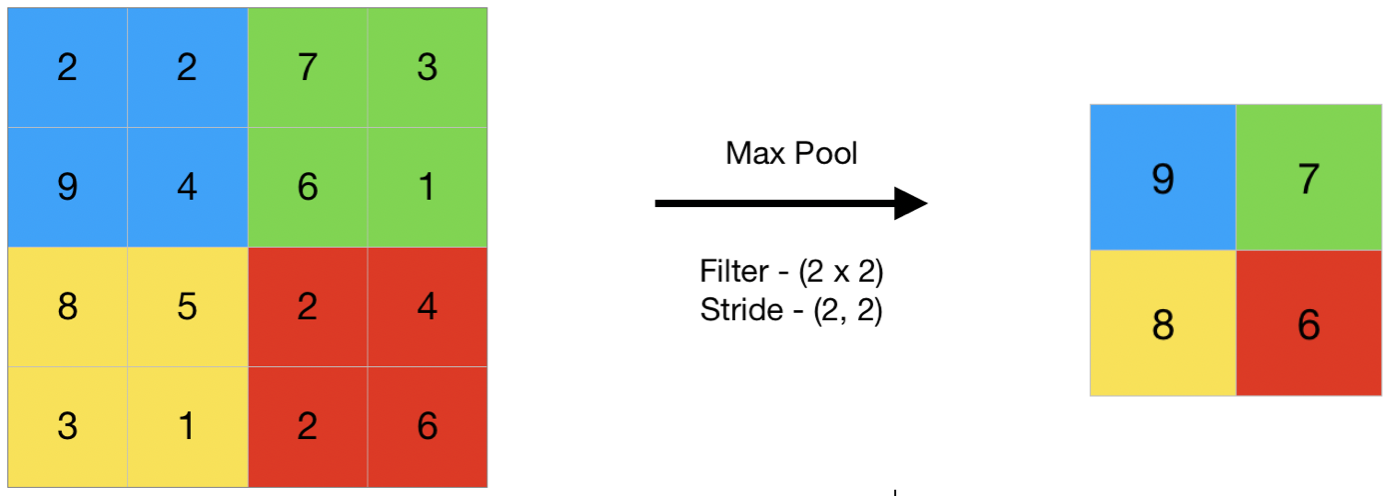

## The dimensions of the next layer after max pooling will be given by the following formulas

$$Height = \Bigl\lfloor \frac{{Height_{prev}} - filter}{stride} \Bigr\rfloor +1$$

$$Width = \Bigl\lfloor \frac{{Width_{prev}} - filter}{stride} \Bigr\rfloor +1$$

$$Channel = Channel_{prev}$$

In [42]:
def pooling_forward(A_prev, filter_size, stride):
    
    
    (num_pic, H_prev, W_prev, Chan_prev) = A_prev.shape 
  
    
    new_Height = int(np.floor((H_prev - filter_size) / stride) + 1)
    new_Width = int(np.floor((W_prev - filter_size) / stride) + 1)
    new_Chan = Chan_prev
    
    A = np.zeros((num_pic, new_Height, new_Width, new_Chan))    
    for i in range(num_pic):
        for h in range(new_Height):
            vert_start = stride * h
            vert_end = vert_start + filter_size

            for w in range(new_Width):     
                hor_start = stride * w
                hor_end = hor_start + filter_size
                for c in range(new_Chan):
                    sliced_A = A_prev[i,vert_start:vert_end, hor_start: hor_end, c]

                    A[i, h, w, c] = np.max(sliced_A)
                    
                    
    return A

In [43]:
np.random.seed(1)
A_prev = np.random.randn(1, 5, 5, 3) # use only 1 picture for simplicity
print(A_prev)
filter_size = 3
stride = 1
A_new = pooling_forward(A_prev, filter_size, stride)
# a 3by3 by n kernel will first see 1.744 as the graetest number, then see 0.9015 on the second iteration.
# note this matrix being printed is slighly delusional, since i'm refering to a 5by 5 by 3 kernel, and this is showing a 5 by 3 by 5 kernel
# do some extra tracing to get the answer of max pooling

assert A_new.shape == (1,3,3,3)
assert np.isclose(A_new[0][0][0][0], 1.74481, atol = 0.01)
assert np.isclose(A_new[0][0][0][1], 0.9015907, atol = 0.01)



[[[[ 1.62434536 -0.61175641 -0.52817175]
   [-1.07296862  0.86540763 -2.3015387 ]
   [ 1.74481176 -0.7612069   0.3190391 ]
   [-0.24937038  1.46210794 -2.06014071]
   [-0.3224172  -0.38405435  1.13376944]]

  [[-1.09989127 -0.17242821 -0.87785842]
   [ 0.04221375  0.58281521 -1.10061918]
   [ 1.14472371  0.90159072  0.50249434]
   [ 0.90085595 -0.68372786 -0.12289023]
   [-0.93576943 -0.26788808  0.53035547]]

  [[-0.69166075 -0.39675353 -0.6871727 ]
   [-0.84520564 -0.67124613 -0.0126646 ]
   [-1.11731035  0.2344157   1.65980218]
   [ 0.74204416 -0.19183555 -0.88762896]
   [-0.74715829  1.6924546   0.05080775]]

  [[-0.63699565  0.19091548  2.10025514]
   [ 0.12015895  0.61720311  0.30017032]
   [-0.35224985 -1.1425182  -0.34934272]
   [-0.20889423  0.58662319  0.83898341]
   [ 0.93110208  0.28558733  0.88514116]]

  [[-0.75439794  1.25286816  0.51292982]
   [-0.29809284  0.48851815 -0.07557171]
   [ 1.13162939  1.51981682  2.18557541]
   [-1.39649634 -1.44411381 -0.50446586]
   [ 0.1

## The process of back propagation for pooling is to take the value which is the greatest due to pooling_foward, and output it to the prev layer by finding that value, while making other values 0. I have a picture that better illustrates what this means
### source https://leonardoaraujosantos.gitbook.io/artificial-inteligence/machine_learning/deep_learning/pooling_layer
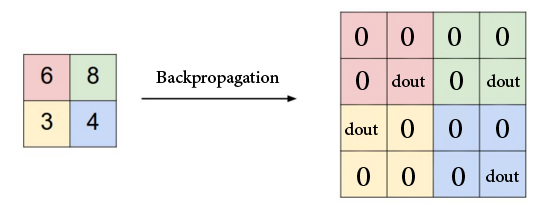


In [57]:

def pooling_backward(grad_A, prev_A, filter_size, stride):
    (num_pic, H_prev, W_prev, Chan_prev) = prev_A.shape
    (num_pic, new_H, new_W, new_Chan) = grad_A.shape
    
    # here the grad_A doesn't necesarily mean the gradient, but rather it's value used to update the neural network. 
    # It is becuase pooling doesn't involve in gradient
    # proof https://leimao.github.io/blog/Max-Pooling-Backpropagation/
    grad_A_prev = np.zeros(prev_A.shape)
    
    
    for i in range(num_pic):
        target_pic = A_prev[i,:,:,:]
        
        for h in range(new_H):  
            vert_start = h * stride
            vert_end = vert_start + filter_size
            for w in range(new_W): 
                
                hor_start = w * stride
                hor_end   = hor_start + filter_size
                for c in range(new_Chan):  
                    
                    sliced_A = target_pic[ vert_start:vert_end, hor_start:hor_end, c ]
                    
                    # get the mask containing the maximum value of the  
                    mask = (sliced_A == np.max(sliced_A))
                    
                    
                    grad_A_prev[i, vert_start:vert_end, hor_start:hor_end, c] += mask * grad_A[i, h, w, c]


    
    return grad_A_prev


        

In [66]:
np.random.seed(1)
A_prev = np.random.randn(1, 4, 3, 2)
stride = 1
filter_size = 2
grad_A_prev = np.random.randn(1,3, 2, 2)
print(A_prev, grad_A_prev)

## output looks about right with the 0 strucure
back = pooling_backward(grad_A_prev, A_prev, filter_size, stride)
assert back.shape == (1, 4, 3, 2)
print(pooling_backward(grad_A_prev, A_prev, filter_size, stride))
#print('dA_prev1[1,1] = ', dA_prev1[1, 1])  


[[[[ 1.62434536 -0.61175641]
   [-0.52817175 -1.07296862]
   [ 0.86540763 -2.3015387 ]]

  [[ 1.74481176 -0.7612069 ]
   [ 0.3190391  -0.24937038]
   [ 1.46210794 -2.06014071]]

  [[-0.3224172  -0.38405435]
   [ 1.13376944 -1.09989127]
   [-0.17242821 -0.87785842]]

  [[ 0.04221375  0.58281521]
   [-1.10061918  1.14472371]
   [ 0.90159072  0.50249434]]]] [[[[ 0.90085595 -0.68372786]
   [-0.12289023 -0.93576943]]

  [[-0.26788808  0.53035547]
   [-0.69166075 -0.39675353]]

  [[-0.6871727  -0.84520564]
   [-0.67124613 -0.0126646 ]]]]
[[[[ 0.          0.        ]
   [ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.63296787  0.        ]
   [ 0.         -1.48589535]
   [-0.81455098  0.        ]]

  [[ 0.          0.        ]
   [-1.35841883  0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.         -0.85787024]
   [ 0.          0.        ]]]]


## This is all that I have. This is not definitely all correct as the CNN used now, because my code is not vectorized(used too many for loops). Also, for pooling layers, I found out that there's also average pooling, which I didn't include in my implementation.


## However, this provides strong foundations for out later part of the work as we understand the logic behind CNN
